In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
#import pandas_datareader.data as web
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [18]:
import statsmodels.api as sm

In [28]:
df = pd.read_csv("ai_count_no_outliers.csv",parse_dates=True,index_col=1)

In [6]:
# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [7]:
# one-step sarima forecast
def sarima_forecast(history, config):
    order, sorder, trend = config
    # define model
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    # fit model
    model_fit = model.fit(disp=False)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = sarima_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    return error

# score a model, return None on failure
def score_model(data, n_test, cfg, debug=False):
    result = None
    # convert config to a key
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    # check for an interesting result
#    if result is not None:
#        print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

# grid search configs
def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a set of sarima configs to try
def sarima_configs(seasonal=[0]):
    models = list()
    # define config lists
    p_params = range(2)
    d_params = range(2)
    q_params = range(5)
    t_params = ['n','c','t','ct']
    P_params = range(5)
    D_params = range(2)
    Q_params = range(2)
    m_params = range(2)
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p, d, q), (P, D, Q, m), t]
                                    models.append(cfg)
    return models

In [8]:
# define dataset
#data = data['y'].values
print(df.shape)
# data split
n_test = 10
# model configs
cfg_list = sarima_configs()
print('Configurations: ', len(cfg_list))
# grid search
scores = grid_search(df['count'].values, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

(366, 2)
Configurations:  3200
done
[(1, 0, 0), (0, 0, 0, 0), 'n'] 9.896627582089744
[(1, 0, 1), (0, 0, 0, 0), 'n'] 9.915024742935053
[(0, 0, 3), (0, 0, 0, 0), 'n'] 10.553925806422857


In [29]:
df.head()

,Unnamed: 0,count
date,,
2020-01-01,0,13.0
2020-01-02,1,22.0
2020-01-03,2,24.0
2020-01-04,3,14.0
2020-01-05,4,6.0


In [30]:
df.drop(['Unnamed: 0'], inplace = True, axis = 1)

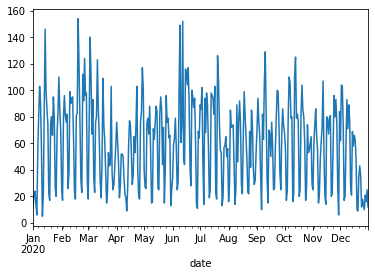

In [31]:
#Draw plot chart
df["count"].plot()

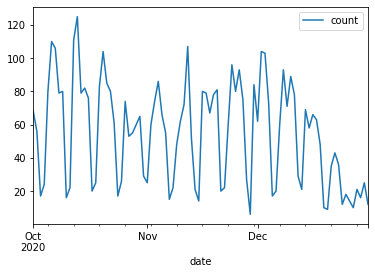

In [13]:
#Use the last 3 months data to show seasonality more clearly
last3mon=df.loc[df.index>="2020-10-01"]
last3mon.plot()

In [14]:
from statsmodels.tsa.statespace.tools import diff 
diffdvds=diff(last3mon, k_diff=1, k_seasonal_diff=True, seasonal_periods=1)
diffdvds

,count
date,
2020-10-03,-27.0
2020-10-04,46.0
2020-10-05,49.0
2020-10-06,-26.0
2020-10-07,-34.0
...,...
2020-12-27,0.0
2020-12-28,15.0
2020-12-29,-16.0


In [32]:
mod = sm.tsa.SARIMAX(df, order=(1,0,0),seasonal_order=(0,0,0,0))
res = mod.fit()
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                  366
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1791.650
Date:                Fri, 11 Feb 2022   AIC                           3587.300
Time:                        13:05:19   BIC                           3595.106
Sample:                    01-01-2020   HQIC                          3590.402
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8792      0.026     33.231      0.000       0.827       0.931
sigma2      1041.5828     69.524     14.982      0.000     905.318    1177.848
Ljung-Box (L1) (Q):                   0.01   Jarque-

In [33]:
#Part IV: Forecasting
#Of course, Python can help us to forecast values even if you don't write the equation.

#If forecast one day ahead
print(res.forecast(1))

#If forecast two days ahead
print(res.forecast(2))

2021-01-01    10.549926
Freq: D, dtype: float64
2021-01-01    10.549926
2021-01-02     9.275079
Freq: D, Name: predicted_mean, dtype: float64


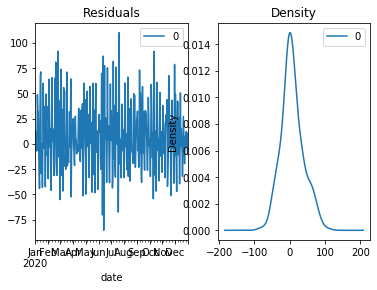

In [34]:
# Plot residual errors
residuals = pd.DataFrame(res.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()


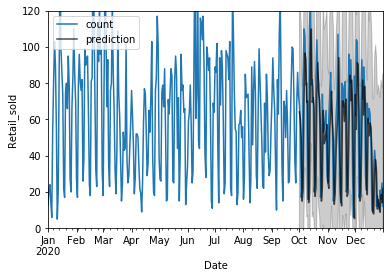

In [35]:
pred = res.get_prediction(start=pd.to_datetime('2020-10-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = df.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='prediction', alpha=.7, color = 'black')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
ax.set_ylim([0, 120])
plt.legend()
plt.show()

In [36]:
y_predicted = pred.predicted_mean
y_truth=df.loc[df.index>="2020-10-01"]
y_truth

,count
date,
2020-10-01,68.0
2020-10-02,56.0
2020-10-03,17.0
2020-10-04,24.0
2020-10-05,80.0
...,...
2020-12-27,10.0
2020-12-28,21.0
2020-12-29,16.0


In [37]:
#Converting columns into arrays
data_date = y_truth.index.to_numpy()
data_count = y_truth['count'].to_numpy()

#Converting into series
data_series = pd.Series(data = data_count, index = data_date)

In [38]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(data_series, y_predicted)

0.5910052954435214

In [39]:
y_predicted

2020-10-01    64.178718
2020-10-02    59.782915
2020-10-03    49.232989
2020-10-04    14.945729
2020-10-05    21.099852
                ...    
2020-12-27    12.308247
2020-12-28     8.791605
2020-12-29    18.462371
2020-12-30    14.066568
2020-12-31    21.979013
Freq: D, Name: predicted_mean, Length: 92, dtype: float64